# Notebook de l'exploration et pre-traitement des questions du corpus v2

## A. Pre-requis

In [1]:
# Importation des librairies

import pandas as pd
import spacy
from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

In [2]:
# Chargement du dataset

dataset = pd.read_csv('dataset/stack_overflow_query_result.csv')

In [3]:
# Information sur le dataset

dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Title          50000 non-null  object 
 1   Body           50000 non-null  object 
 2   Tags           50000 non-null  object 
 3   Id             50000 non-null  int64  
 4   Score          50000 non-null  int64  
 5   ViewCount      50000 non-null  int64  
 6   FavoriteCount  0 non-null      float64
 7   AnswerCount    50000 non-null  int64  
dtypes: float64(1), int64(4), object(3)
memory usage: 3.1+ MB


In [4]:
# Description du dataset

dataset.describe()

,Id,Score,ViewCount,FavoriteCount,AnswerCount
count,5.000000e+04,50000.000000,5.000000e+04,0.0,50000.00000
mean,1.562872e+06,25.357040,2.371003e+04,NaN,3.58756
std,7.694544e+05,217.521498,1.506203e+05,NaN,3.99613
min,4.000000e+00,-6.000000,2.900000e+01,NaN,0.00000
25%,9.314418e+05,1.000000,1.038000e+03,NaN,1.00000
50%,1.614784e+06,2.000000,2.637000e+03,NaN,3.00000
75%,2.239268e+06,7.000000,8.269000e+03,NaN,4.00000
max,2.776234e+06,20372.000000,1.192372e+07,NaN,131.00000


## B. Nettoyage

### Formatage de la variable 'Tags'

In [5]:
# Nettoyer le formatage de la variables 'Tags' en enlevant '<' puis en supprimant le dernier caractere '>' et en decoupant la chaine par '>'

def process_tags(tags):
    """
    Transforme une chaîne de caractères contenant des tags délimités par '<' et '>'.
    
    Cette fonction remplace les caractères '<' dans la chaîne par des chaînes vides, 
    enlève le dernier caractère de la chaîne résultante, puis divise la chaîne restante 
    en une liste de sous-chaînes en utilisant '>' comme délimiteur.

    Args:
        tags (str): Une chaîne de caractères contenant des tags délimités par '<' et '>'.

    Returns:
        list: Une liste de chaînes, où chaque chaîne est un tag extrait de l'entrée.
    """
    return tags.replace('<', '')[0:-1].split('>')

dataset['preproc_tags'] = dataset['Tags'].apply(process_tags)

### Suppression de la variable 'FavoriteCount'

In [6]:
# Suppression de la variable 'FavoriteCount' du dataset.
# Cette variable est vide du fait d'un bug avec Stack Exchange Data Explorer

dataset.drop(columns='FavoriteCount', inplace=True)

## C. Pre-processing

In [7]:
# Charger le modèle de langue
nlp = spacy.load("en_core_web_sm")

# Liste des mots spécifiques à conserver (comme "C++", "C#", etc.)
whitelist = ["c#", "c++"]

# Fonction pour le traitement du texte
def preprocess_text(text):
    # Enlever les balises HTML
    soup = BeautifulSoup(text, "html.parser").get_text()
    doc = nlp(soup)  # Traiter le texte avec spaCy
    
    # Expression régulière pour vérifier les caractères anglais uniquement (ASCII)
    def is_english(token):
        return re.match(r'^[a-zA-Z0-9+.#]+$', token)

    tokens = [
        # Utiliser le lemme sauf si le mot est dans la whitelist
        token.lemma_.lower() if token.lemma_.lower() not in whitelist else token.text.lower()
        for token in doc 
        if not token.is_stop                         # Ne pas inclure les stopwords
        and not token.is_punct                       # Ne pas inclure la ponctuation
        and not token.like_num                       # Ne pas inclure les chiffres
        and len(token.lemma_) >= 3                    # Exclure les tokens trop courts
        and (is_english(token.text) or token.text.lower() in whitelist)  # Garder les mots anglais ou ceux de la whitelist
    ]
    print(tokens)
    return tokens

### /!\ LA CELLULE SUIVANTE A UN TEMPS D'EXECUTION TRES LONG /!\

In [8]:
'''
# Pre-processing du 'Body'

dataset['preproc_body'] = dataset['Body'].apply(preprocess_text)

# Pre-processing du 'Title'

dataset['preproc_title'] = dataset['Title'].apply(preprocess_text)
'''

"\n# Pre-processing du 'Body'\n\ndataset['preproc_body'] = dataset['Body'].apply(preprocess_text)\n\n# Pre-processing du 'Title'\n\ndataset['preproc_title'] = dataset['Title'].apply(preprocess_text)\n"

In [9]:
# Le code ci dessous remplace la cellule precente qui a un temps d'execution beaucoup trop long.
# Il permet de charger les données pré-traitées pour gagner du temps

# Fonction pour le traitement du texte
def convert_columns(text):
    """
    Convertit une chaîne de caractères en liste de mots en remplaçant certains caractères spéciaux et en séparant les éléments.

    Args:
        text (str): La chaîne de caractères à traiter. Celle-ci peut contenir des crochets, des virgules et des guillemets.

    Returns:
        list: Une liste de mots extraits de la chaîne, avec les caractères spéciaux remplacés par des espaces.
    """
    return text.replace("[", " ").replace("]", " ").replace(",", " ").replace("'", " ").split()

# Chargement du dataset pré-traité
df = pd.read_csv("dataset/dataset-clean-v2.csv")

# Appliquer la fonction 'convert_columns' aux variables 'preproc_tags', 'preproc_body', 'preproc_title'
df['preproc_title'] = df['preproc_title'].apply(convert_columns)
df['preproc_body'] = df['preproc_body'].apply(convert_columns)
df['preproc_tags'] = df['preproc_tags'].apply(convert_columns)

# Creation de la variable 'text' qui regroupe les colonnes 'preproc_title' et 'preproc_body'
df['corpus'] = df['preproc_body'].apply(lambda x: ' '.join(x)) + ' ' + df['preproc_title'].apply(lambda x: ' '.join(x))

## D. Exploration des donnees

### 1. Analyse univariee

#### Nuages de mots

##### Nuage de mots de la variable 'preproc_tags'

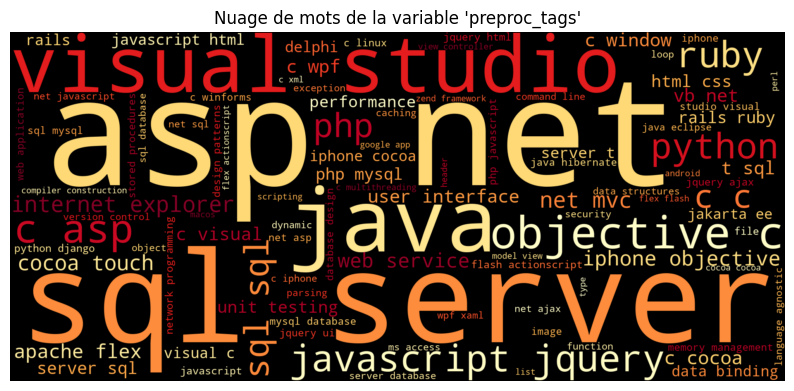

In [10]:
# Supposons que ton corpus soit une liste de phrases ou un seul texte prétraité
corpus = ' '.join([' '.join(tokens) for tokens in df['preproc_tags']])  # Ajuste selon ta variable

# Créer un nuage de mots
wordcloud = WordCloud(width=2000, 
    height=900, 
    max_words=100, 
    background_color='black', 
    colormap='YlOrRd').generate(corpus)

# Afficher le nuage de mots
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Enlever les axes
plt.title("Nuage de mots de la variable 'preproc_tags'")
plt.show()

##### Nuage de mots de la variable 'preproc_title'

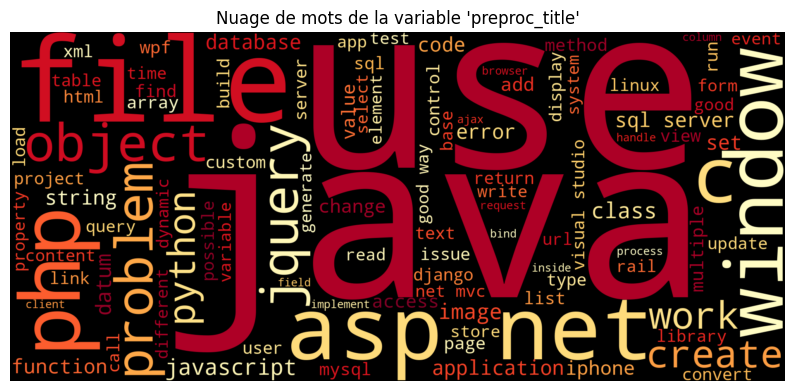

In [11]:
# Supposons que ton corpus soit une liste de phrases ou un seul texte prétraité
corpus = ' '.join([' '.join(tokens) for tokens in df['preproc_title']])  # Ajuste selon ta variable

# Créer un nuage de mots
wordcloud = WordCloud(width=2000, 
    height=900, 
    max_words=100, 
    background_color='black', 
    colormap='YlOrRd').generate(corpus)

# Afficher le nuage de mots
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Enlever les axes
plt.title("Nuage de mots de la variable 'preproc_title'")
plt.show()

##### Nuage de mots de la variable 'preproc_body'

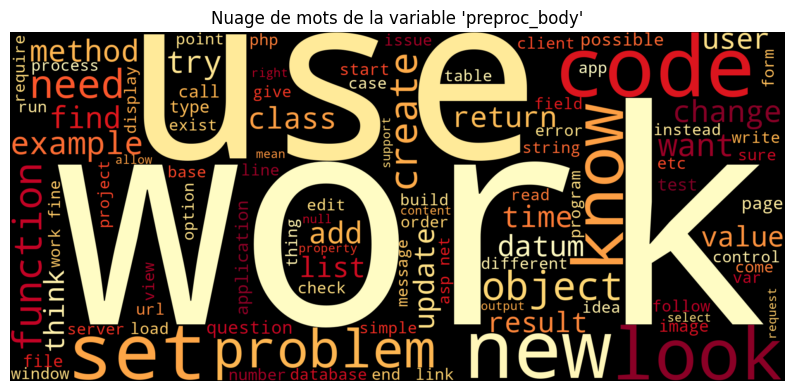

In [12]:
# Supposons que ton corpus soit une liste de phrases ou un seul texte prétraité
corpus = ' '.join([' '.join(tokens) for tokens in df['preproc_body']])  # Ajuste selon ta variable

# Créer un nuage de mots
wordcloud = WordCloud(width=2000, 
    height=900, 
    max_words=100, 
    background_color='black', 
    colormap='YlOrRd').generate(corpus)

# Afficher le nuage de mots
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Enlever les axes
plt.title("Nuage de mots de la variable 'preproc_body'")
plt.show()

#### Frequences des mots

##### Frequences des mots les plus courants dans la variable 'preproc_tags'

/var/folders/vw/3213t_m15dg993rbl1r9k5t00000gn/T/ipykernel_1309/1778641251.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='term', data=word_freq.head(20), palette='viridis')


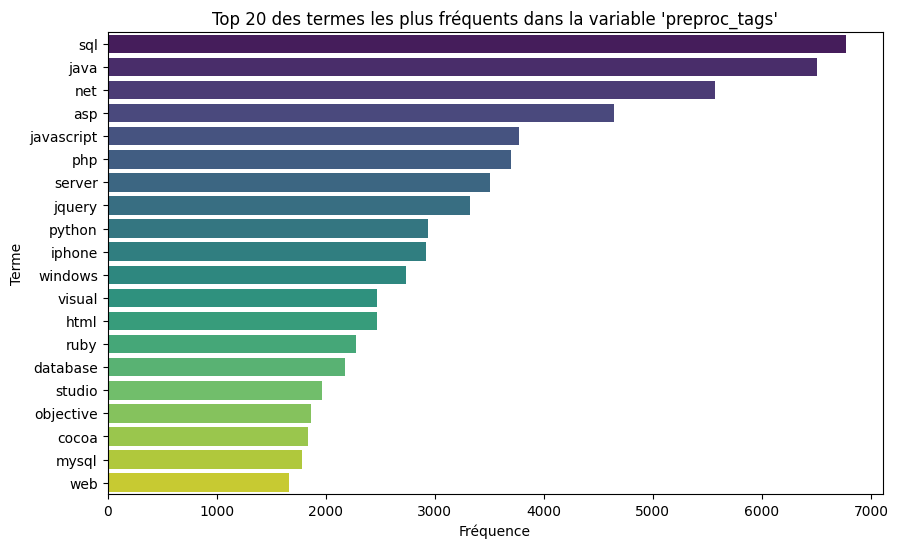

In [13]:
# Fusionne les listes de tokens en une chaîne de caractères par document
corpus = [' '.join(tokens) for tokens in df['preproc_tags']]  # Ajuste selon ta variable

# Créer un objet CountVectorizer pour compter les mots dans le corpus
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)

# Somme des occurrences de chaque terme (sur toutes les phrases)
word_counts = X.toarray().sum(axis=0)

# Associer les termes avec leurs fréquences
word_freq = pd.DataFrame({
    'term': vectorizer.get_feature_names_out(),
    'count': word_counts
})

# Trier par fréquence décroissante
word_freq = word_freq.sort_values(by='count', ascending=False)

# Visualiser les 50 termes les plus fréquents
plt.figure(figsize=(10, 6))
sns.barplot(x='count', y='term', data=word_freq.head(20), palette='viridis')
plt.title("Top 20 des termes les plus fréquents dans la variable 'preproc_tags'")
plt.xlabel('Fréquence')
plt.ylabel('Terme')
plt.show()

##### Frequences des mots les plus courants dans la variable 'preproc_title'

/var/folders/vw/3213t_m15dg993rbl1r9k5t00000gn/T/ipykernel_1309/1536183926.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='term', data=word_freq.head(20), palette='viridis')


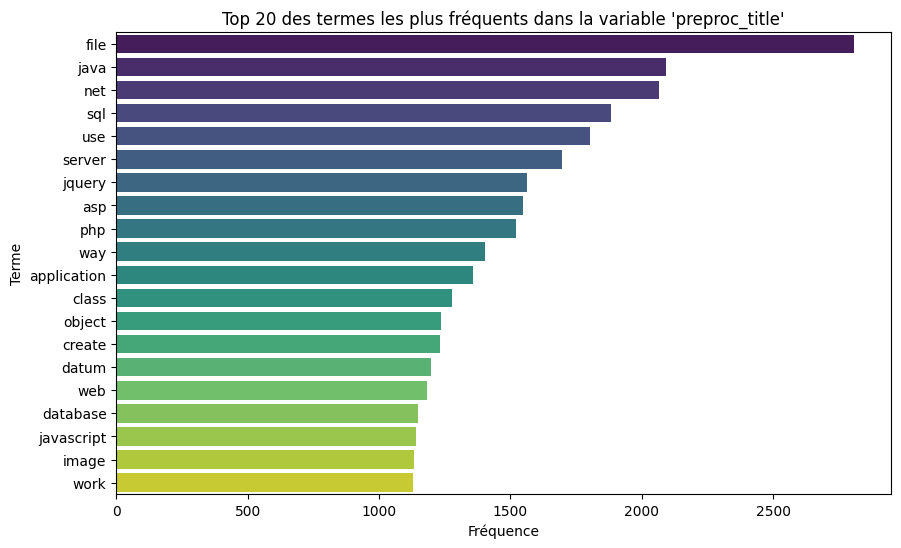

In [14]:
# Fusionne les listes de tokens en une chaîne de caractères par document
corpus = [' '.join(tokens) for tokens in df['preproc_title']]  # Ajuste selon ta variable

# Créer un objet CountVectorizer pour compter les mots dans le corpus
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)

# Somme des occurrences de chaque terme (sur toutes les phrases)
word_counts = X.toarray().sum(axis=0)

# Associer les termes avec leurs fréquences
word_freq = pd.DataFrame({
    'term': vectorizer.get_feature_names_out(),
    'count': word_counts
})

# Trier par fréquence décroissante
word_freq = word_freq.sort_values(by='count', ascending=False)

# Visualiser les 50 termes les plus fréquents
plt.figure(figsize=(10, 6))
sns.barplot(x='count', y='term', data=word_freq.head(20), palette='viridis')
plt.title("Top 20 des termes les plus fréquents dans la variable 'preproc_title'")
plt.xlabel('Fréquence')
plt.ylabel('Terme')
plt.show()

##### Frequences des mots les plus courants dans la variable 'preproc_body'

/var/folders/vw/3213t_m15dg993rbl1r9k5t00000gn/T/ipykernel_1309/2549325953.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='term', data=word_freq.head(20), palette='viridis')


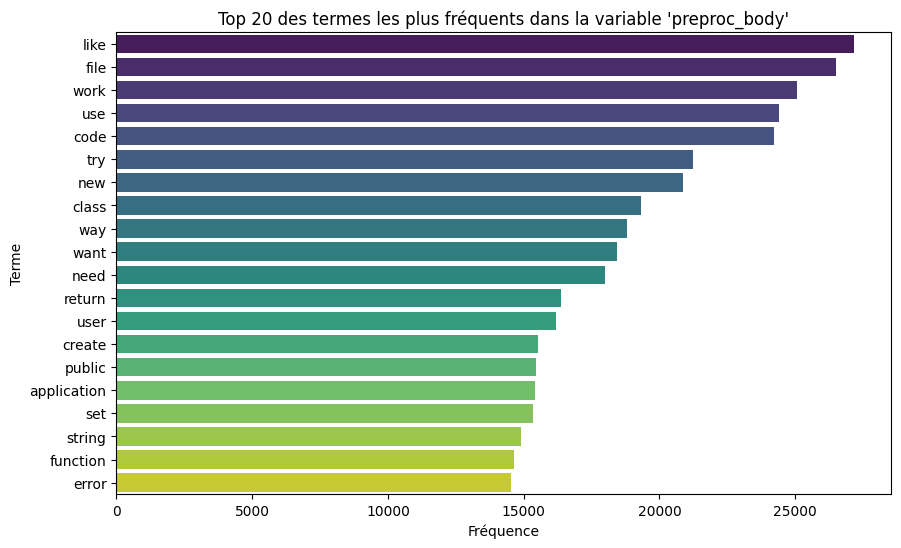

In [15]:
# Fusionne les listes de tokens en une chaîne de caractères par document
corpus = [' '.join(tokens) for tokens in df['preproc_body']]  # Ajuste selon ta variable

# Créer un objet CountVectorizer pour compter les mots dans le corpus
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)

# Somme des occurrences de chaque terme (sur toutes les phrases)
word_counts = X.toarray().sum(axis=0)

# Associer les termes avec leurs fréquences
word_freq = pd.DataFrame({
    'term': vectorizer.get_feature_names_out(),
    'count': word_counts
})

# Trier par fréquence décroissante
word_freq = word_freq.sort_values(by='count', ascending=False)

# Visualiser les 50 termes les plus fréquents
plt.figure(figsize=(10, 6))
sns.barplot(x='count', y='term', data=word_freq.head(20), palette='viridis')
plt.title("Top 20 des termes les plus fréquents dans la variable 'preproc_body'")
plt.xlabel('Fréquence')
plt.ylabel('Terme')
plt.show()

### 2. Analyse multivariee

#### Analyse en Composantes Principales

##### ACP de la variable 'preproc_title'

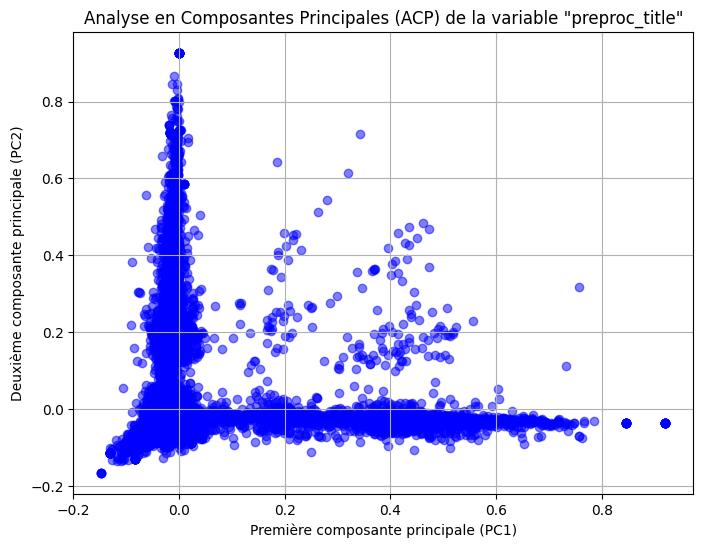

In [16]:
# Creation du corpus pour l'ACP a partir de la variable 'preproc_title'
corpus = [' '.join(tokens) for tokens in df['preproc_title']]  # Ajuste selon ta variable

# Étape 1: Transformer le texte en vecteurs TF-IDF
vectorizer = TfidfVectorizer(max_features=1000)  # Limiter à 1000 caractéristiques pour réduire la dimensionnalité
X_tfidf = vectorizer.fit_transform(corpus)

# Étape 2: Appliquer l'ACP
pca = PCA(n_components=2)  # Réduire à 2 dimensions pour la visualisation
X_pca = pca.fit_transform(X_tfidf.toarray())

# Créer un DataFrame pour stocker les résultats de l'ACP
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])

# Étape 3: Visualiser les deux premières composantes principales
plt.figure(figsize=(8, 6))
plt.scatter(df_pca['PC1'], df_pca['PC2'], alpha=0.5, c='blue')
plt.title('Analyse en Composantes Principales (ACP) de la variable "preproc_title"')
plt.xlabel('Première composante principale (PC1)')
plt.ylabel('Deuxième composante principale (PC2)')
plt.grid(True)
plt.show()

In [17]:
# Récupérer les termes du vectorizer
terms = vectorizer.get_feature_names_out()

# Pour chaque composante, on regarde les termes avec les plus fortes pondérations
# PC1 : Première composante principale
loading_scores_pc1 = pca.components_[0]  # Coefficients des termes dans la première composante
top_terms_idx_pc1 = loading_scores_pc1.argsort()[-10:]  # Les 10 termes les plus influents pour PC1

# PC2 : Deuxième composante principale
loading_scores_pc2 = pca.components_[1]  # Coefficients des termes dans la deuxième composante
top_terms_idx_pc2 = loading_scores_pc2.argsort()[-10:]  # Les 10 termes les plus influents pour PC2

# Afficher les termes influents pour chaque composante
print(f"Top termes pour PC1 (axe X) : {[terms[i] for i in top_terms_idx_pc1]}")
print(f"Top termes pour PC2 (axe Y) : {[terms[i] for i in top_terms_idx_pc2]}")

Top termes pour PC1 (axe X) : ['jquery', 'vb', 'page', 'ajax', 'application', 'control', 'web', 'mvc', 'asp', 'net']
Top termes pour PC2 (axe Y) : ['column', 'mysql', 'procedure', 'store', 'linq', 'table', 'query', 'database', 'server', 'sql']


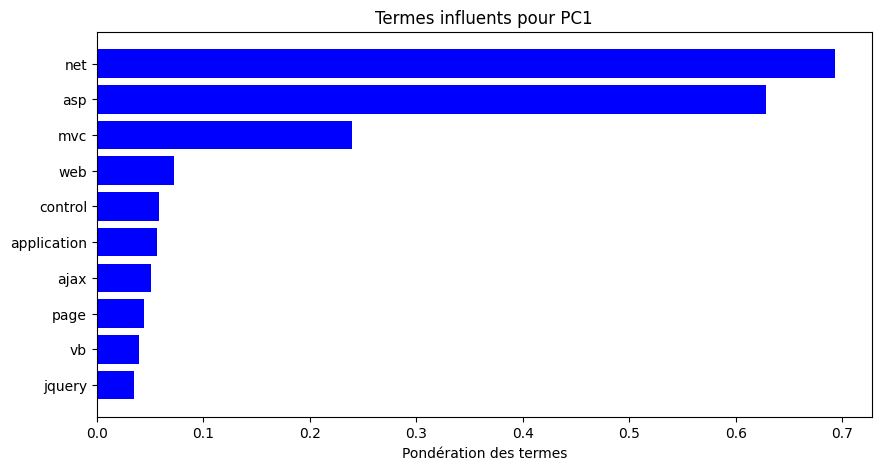

In [18]:
# Sélectionner les termes avec les plus fortes pondérations pour PC1
top_terms_pc1 = [terms[i] for i in top_terms_idx_pc1]
top_scores_pc1 = loading_scores_pc1[top_terms_idx_pc1]

# Visualiser les termes influents pour PC1
plt.figure(figsize=(10, 5))
plt.barh(top_terms_pc1, top_scores_pc1, color='blue')
plt.xlabel('Pondération des termes')
plt.title('Termes influents pour PC1')
plt.show()

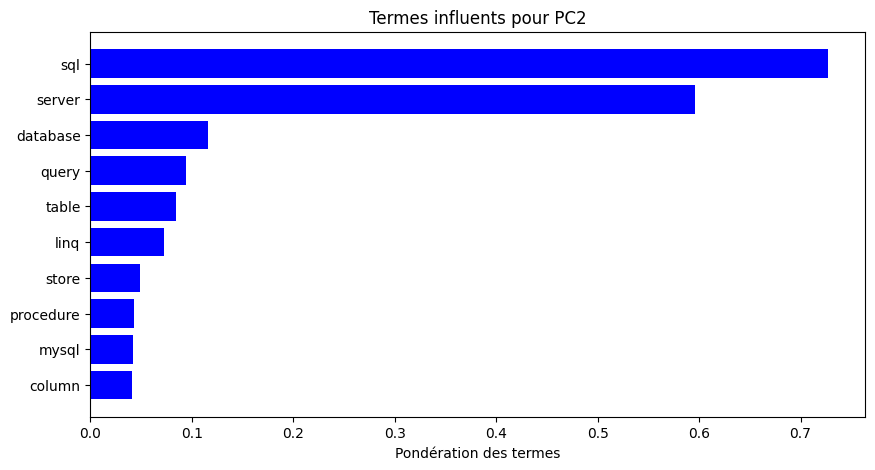

In [19]:
# Sélectionner les termes avec les plus fortes pondérations pour PC2
top_terms_pc2 = [terms[i] for i in top_terms_idx_pc2]
top_scores_pc2 = loading_scores_pc2[top_terms_idx_pc2]

# Visualiser les termes influents pour PC1
plt.figure(figsize=(10, 5))
plt.barh(top_terms_pc2, top_scores_pc2, color='blue')
plt.xlabel('Pondération des termes')
plt.title('Termes influents pour PC2')
plt.show()

##### ACP de la variable 'preproc_tags'

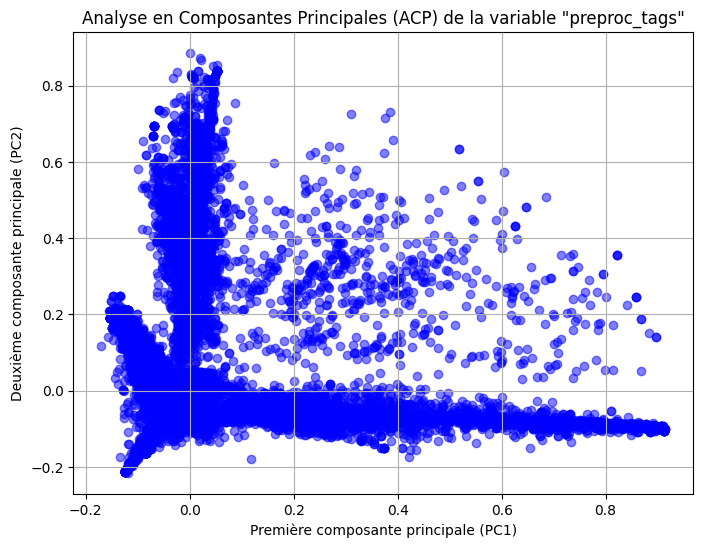

In [20]:
# Creation du corpus pour l'ACP a partir de la variable 'preproc_tags'
corpus = [' '.join(tokens) for tokens in df['preproc_tags']]  # Ajuste selon ta variable

# Étape 1: Transformer le texte en vecteurs TF-IDF
vectorizer = TfidfVectorizer(max_features=1000)  # Limiter à 1000 caractéristiques pour réduire la dimensionnalité
X_tfidf = vectorizer.fit_transform(corpus)

# Étape 2: Appliquer l'ACP
pca = PCA(n_components=2)  # Réduire à 2 dimensions pour la visualisation
X_pca = pca.fit_transform(X_tfidf.toarray())

# Créer un DataFrame pour stocker les résultats de l'ACP
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])

# Étape 3: Visualiser les deux premières composantes principales
plt.figure(figsize=(8, 6))
plt.scatter(df_pca['PC1'], df_pca['PC2'], alpha=0.5, c='blue')
plt.title('Analyse en Composantes Principales (ACP) de la variable "preproc_tags"')
plt.xlabel('Première composante principale (PC1)')
plt.ylabel('Deuxième composante principale (PC2)')
plt.grid(True)
plt.show()

In [21]:
# Récupérer les termes du vectorizer
terms = vectorizer.get_feature_names_out()

# Pour chaque composante, on regarde les termes avec les plus fortes pondérations
# PC1 : Première composante principale
loading_scores_pc1 = pca.components_[0]  # Coefficients des termes dans la première composante
top_terms_idx_pc1 = loading_scores_pc1.argsort()[-10:]  # Les 10 termes les plus influents pour PC1

# PC2 : Deuxième composante principale
loading_scores_pc2 = pca.components_[1]  # Coefficients des termes dans la deuxième composante
top_terms_idx_pc2 = loading_scores_pc2.argsort()[-10:]  # Les 10 termes les plus influents pour PC2

# Afficher les termes influents pour chaque composante
print(f"Top termes pour PC1 (axe X) : {[terms[i] for i in top_terms_idx_pc1]}")
print(f"Top termes pour PC2 (axe Y) : {[terms[i] for i in top_terms_idx_pc2]}")

Top termes pour PC1 (axe X) : ['stored', 'asp', 'mysql', 'net', 'linq', '2008', 'database', '2005', 'server', 'sql']
Top termes pour PC2 (axe Y) : ['studio', 'iis', 'html', 'vb', 'ajax', 'javascript', 'mvc', 'jquery', 'asp', 'net']


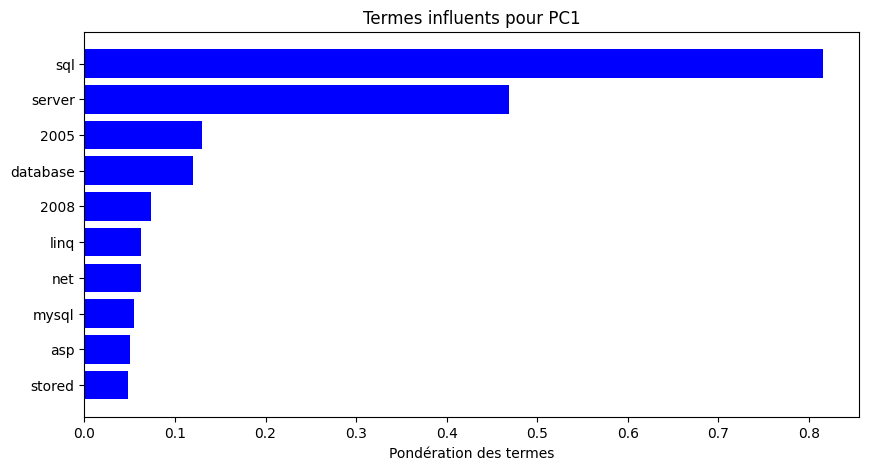

In [22]:
# Sélectionner les termes avec les plus fortes pondérations pour PC1
top_terms_pc1 = [terms[i] for i in top_terms_idx_pc1]
top_scores_pc1 = loading_scores_pc1[top_terms_idx_pc1]

# Visualiser les termes influents pour PC1
plt.figure(figsize=(10, 5))
plt.barh(top_terms_pc1, top_scores_pc1, color='blue')
plt.xlabel('Pondération des termes')
plt.title('Termes influents pour PC1')
plt.show()

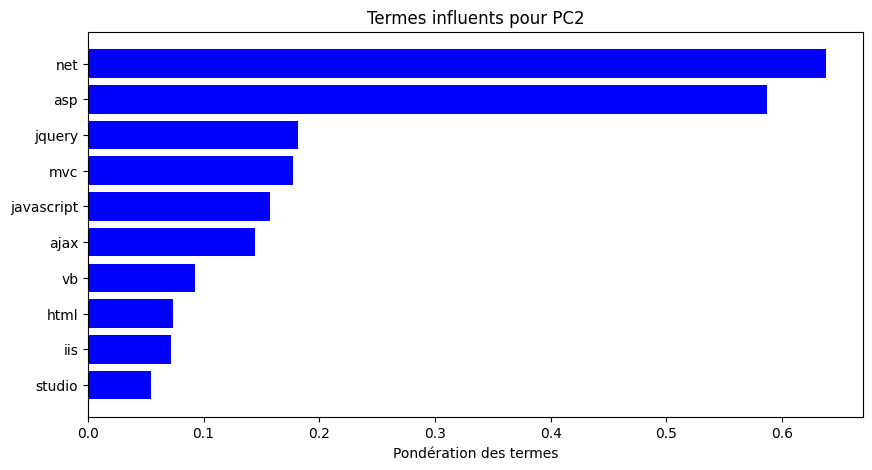

In [23]:
# Sélectionner les termes avec les plus fortes pondérations pour PC2
top_terms_pc2 = [terms[i] for i in top_terms_idx_pc2]
top_scores_pc2 = loading_scores_pc2[top_terms_idx_pc2]

# Visualiser les termes influents pour PC1
plt.figure(figsize=(10, 5))
plt.barh(top_terms_pc2, top_scores_pc2, color='blue')
plt.xlabel('Pondération des termes')
plt.title('Termes influents pour PC2')
plt.show()

##### ACP de la variable 'preproc_body'

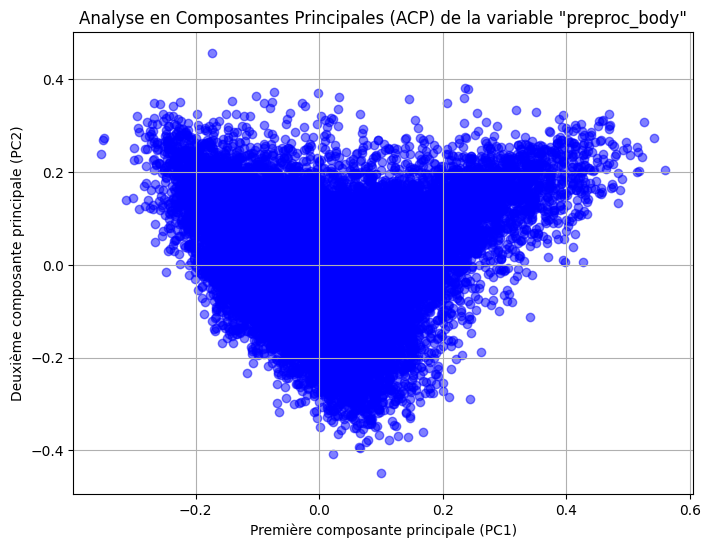

In [24]:
# Creation du corpus pour l'ACP a partir de la variable 'preproc_body'
corpus = [' '.join(tokens) for tokens in df['preproc_body']]  # Ajuste selon ta variable

# Étape 1: Transformer le texte en vecteurs TF-IDF
vectorizer = TfidfVectorizer(max_features=1000)  # Limiter à 1000 caractéristiques pour réduire la dimensionnalité
X_tfidf = vectorizer.fit_transform(corpus)

# Étape 2: Appliquer l'ACP
pca = PCA(n_components=2)  # Réduire à 2 dimensions pour la visualisation
X_pca = pca.fit_transform(X_tfidf.toarray())

# Créer un DataFrame pour stocker les résultats de l'ACP
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])

# Étape 3: Visualiser les deux premières composantes principales
plt.figure(figsize=(8, 6))
plt.scatter(df_pca['PC1'], df_pca['PC2'], alpha=0.5, c='blue')
plt.title('Analyse en Composantes Principales (ACP) de la variable "preproc_body"')
plt.xlabel('Première composante principale (PC1)')
plt.ylabel('Deuxième composante principale (PC2)')
plt.grid(True)
plt.show()

In [25]:
# Récupérer les termes du vectorizer
terms = vectorizer.get_feature_names_out()

# Pour chaque composante, on regarde les termes avec les plus fortes pondérations
# PC1 : Première composante principale
loading_scores_pc1 = pca.components_[0]  # Coefficients des termes dans la première composante
top_terms_idx_pc1 = loading_scores_pc1.argsort()[-10:]  # Les 10 termes les plus influents pour PC1

# PC2 : Deuxième composante principale
loading_scores_pc2 = pca.components_[1]  # Coefficients des termes dans la deuxième composante
top_terms_idx_pc2 = loading_scores_pc2.argsort()[-10:]  # Les 10 termes les plus influents pour PC2

# Afficher les termes influents pour chaque composante
print(f"Top termes pour PC1 (axe X) : {[terms[i] for i in top_terms_idx_pc1]}")
print(f"Top termes pour PC2 (axe Y) : {[terms[i] for i in top_terms_idx_pc2]}")

Top termes pour PC1 (axe X) : ['function', 'void', 'new', 'object', 'value', 'int', 'return', 'string', 'class', 'public']
Top termes pour PC2 (axe Y) : ['int', 'error', 'test', 'string', 'void', 'java', 'project', 'public', 'class', 'file']


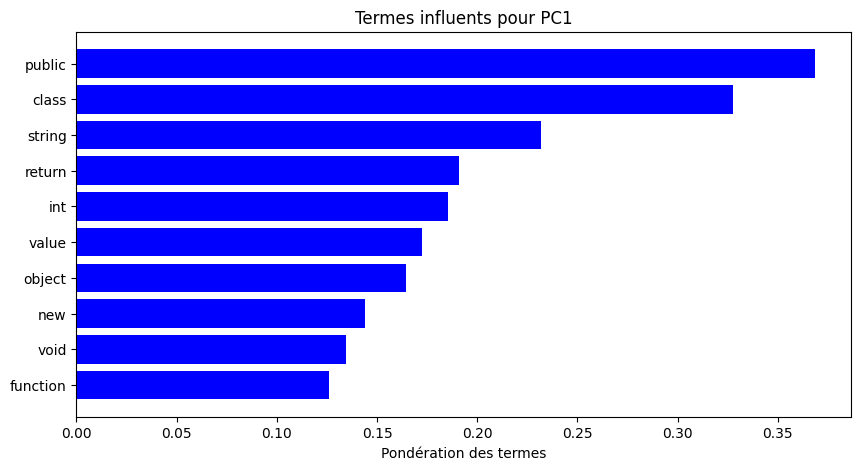

In [26]:
# Sélectionner les termes avec les plus fortes pondérations pour PC1
top_terms_pc1 = [terms[i] for i in top_terms_idx_pc1]
top_scores_pc1 = loading_scores_pc1[top_terms_idx_pc1]

# Visualiser les termes influents pour PC1
plt.figure(figsize=(10, 5))
plt.barh(top_terms_pc1, top_scores_pc1, color='blue')
plt.xlabel('Pondération des termes')
plt.title('Termes influents pour PC1')
plt.show()

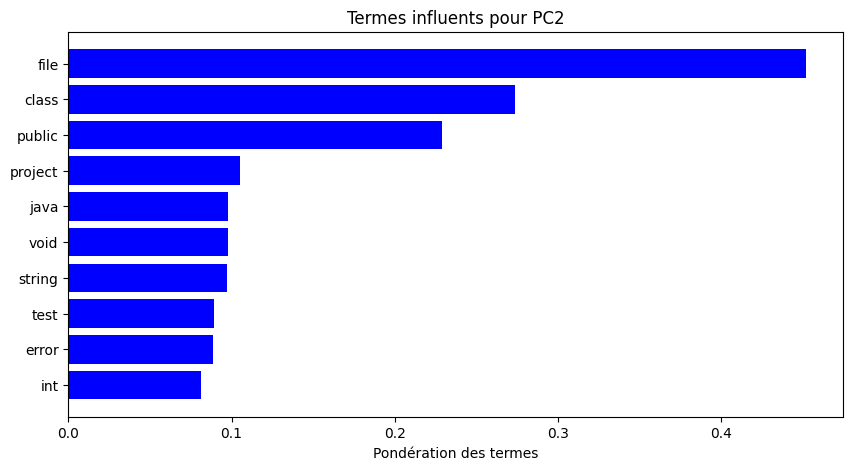

In [27]:
# Sélectionner les termes avec les plus fortes pondérations pour PC2
top_terms_pc2 = [terms[i] for i in top_terms_idx_pc2]
top_scores_pc2 = loading_scores_pc2[top_terms_idx_pc2]

# Visualiser les termes influents pour PC1
plt.figure(figsize=(10, 5))
plt.barh(top_terms_pc2, top_scores_pc2, color='blue')
plt.xlabel('Pondération des termes')
plt.title('Termes influents pour PC2')
plt.show()